# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


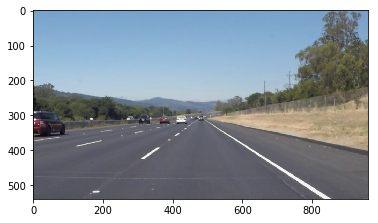

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [59]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_seg = []
    left_slope = []
    
    right_seg = []
    right_slope = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            # slope
            m = (y2 - y1) / (x2 - x1) 
            #print ("Slope", m)
            
            # get left and right segment arrays
            if m < 0.2 and m > -0.8: 
                left_seg.append([x1, y1])
                left_seg.append([x2, y2])
                left_slope.append(m)
        
            elif m > 0.2 and m < 0.8:
                right_seg.append([x1, y1])
                right_seg.append([x2, y2])
                right_slope.append(m)
     
    #print (left_seg, right_seg)
    
    # means (used as mean x, y and m)
    mean_left = np.mean(left_seg, axis=0)
    mean_right = np.mean(right_seg, axis=0)
    mean_left_slope = np.mean(left_slope)
    mean_right_slope = np.mean(right_slope)
    
    #print (mean_left, mean_right)
    #print (mean_left_slope, mean_right_slope)
    
    
    # intercepts (b = y - mx)
    intercept_left = mean_left[1] - mean_left_slope * mean_left[0]
    intercept_right = mean_right[1] - mean_right_slope * mean_right[0]
    
    #print (intercept_left, intercept_right)
    
    
    # calculcate individual x (x = (y - b) / m
    y_min = img.shape[1] - y_axis_mask
    y_max = y_axis_mask
    
    x1 = int((y_min - intercept_left) / mean_left_slope)
    x2 = int((y_max - intercept_left) / mean_left_slope)
    cv2.line(img, (x1, y_min), (x2, y_max), color, thickness)
    
    x1 = int((y_min - intercept_right) / mean_right_slope)
    x2 = int((y_max - intercept_right) / mean_right_slope)
    cv2.line(img, (x1, y_min), (x2, y_max), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [60]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [61]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


# parameters
kernel_size = 5
low_threshold = 50
high_threshold = 150
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
x_axis_mask_left = 450
x_axis_mask_right = 490
y_axis_mask = 320



def pipeline(directoy, filename, test=False):
    image_url =  directoy + '/' + filename
    output_directory = 'test_images_output'
    output_url = output_directory + '/' + filename
    
    # Read image
    image = mpimg.imread(image_url)
    if test:
        print ('##### Test Mode: Image " + filename + " #####')
        plt.imshow(image)
        plt.show()

    # Create mask
    mask = np.array([[(0, image.shape[0]),
                      (x_axis_mask_left, y_axis_mask), 
                      (x_axis_mask_right, y_axis_mask), 
                      (image.shape[1], image.shape[0])]
                    ], dtype=np.int32)


    # Show masked image for check
    masked_image = region_of_interest(image, mask)
    # only in test mode
    if test:
        print ('##### Test Mode: Masked image #####')
        plt.imshow(masked_image)
        plt.show()



    # Grayscale image
    gray_image = grayscale(image)
    # only in test mode
    if test:
        print ('##### Test Mode: Grayscale #####')
        plt.imshow(gray_image, cmap='gray')
        plt.show()



    # Gaussian smoothing
    blur_gray_image = gaussian_blur(gray_image, kernel_size)
    # only in test mode
    if test:
        print ('##### Test Mode: Gaussian #####')
        plt.imshow(blur_gray_image, cmap='gray')
        plt.show()



    # Canny
    canny_image = cv2.Canny(blur_gray_image, low_threshold, high_threshold)
    # only in test mode
    if test:
        print ('##### Test Mode: Canny #####')
        plt.imshow(canny_image, cmap='gray')
        plt.show()



    # Apply mask to canny
    masked_canny_image = region_of_interest(canny_image, mask)
    # only in test mode
    if test:
        print ('##### Test Mode: Masked canny #####')
        plt.imshow(masked_canny_image, cmap='gray')
        plt.show()



    # Hough transformation
    hough_image = hough_lines(masked_canny_image, rho, theta, threshold, min_line_length, max_line_gap)
    # only in test mode
    if test:
        print ('##### Test Mode: Hough #####')
        plt.imshow(hough_image)
        plt.show()



    # Overlay of hough image on canny image
    copy_canny_image = np.dstack((canny_image, canny_image, canny_image))
    overlay_hough_canny_image = cv2.addWeighted(copy_canny_image, 0.8, hough_image, 1, 0) 
    # only in test mode
    if test:
        print ('##### Test Mode: Overlay hough on canny #####')
        plt.imshow(overlay_hough_canny_image)
        plt.show()



    # Overlay of hough image on original image
    output_image = cv2.addWeighted(image, 0.8, hough_image, 1, 0) 
    if test:
        print ('##### Test Mode: Output " + filename + " #####')
        plt.imshow(output_image)
        plt.show()
        
    
    # save image
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    mpimg.imsave(output_url, output_image)





######## Apply to test images ########
directory = 'test_images'
#filename = 'solidYellowCurve.jpg'
#pipeline(directory, filename, True)

for filename in os.listdir("test_images/"):
    pipeline(directory, filename)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [63]:
def process_image(image):
    # Read image
    #image = mpimg.imread(image_url)
    
    # Create mask
    mask = np.array([[(0, image.shape[0]),
                      (x_axis_mask_left, y_axis_mask), 
                      (x_axis_mask_right, y_axis_mask), 
                      (image.shape[1], image.shape[0])]
                    ], dtype=np.int32)


    # Show masked image for check
    masked_image = region_of_interest(image, mask)
    
    # Grayscale image
    gray_image = grayscale(image)
    
    # Gaussian smoothing
    blur_gray_image = gaussian_blur(gray_image, kernel_size)
    
    # Canny
    canny_image = cv2.Canny(blur_gray_image, low_threshold, high_threshold)
    
    # Apply mask to canny
    masked_canny_image = region_of_interest(canny_image, mask)
    
    # Hough transformation
    hough_image = hough_lines(masked_canny_image, rho, theta, threshold, min_line_length, max_line_gap)

    # Overlay of hough image on canny image
    #copy_canny_image = np.dstack((canny_image, canny_image, canny_image))
    #overlay_hough_canny_image = cv2.addWeighted(copy_canny_image, 0.8, hough_image, 1, 0) 

    # Overlay of hough image on original image
    result = cv2.addWeighted(image, 0.8, hough_image, 1, 0) 
    
    return result

Let's try the one with the solid white lane on the right first ...

In [64]:
directory = 'test_videos_output'
if not os.path.exists(directory):
        os.makedirs(directory)
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:03<00:00, 63.01it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.51 s, sys: 272 ms, total: 3.78 s
Wall time: 4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [55]:
directory = 'test_videos_output'
if not os.path.exists(directory):
        os.makedirs(directory)
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[[106 537 416 350]]

 [[217 479 440 339]]

 [[666 425 775 495]]

 [[658 427 758 497]]

 [[105 538 316 411]]

 [[124 538 185 501]]

 [[414 350 456 325]]

 [[711 455 758 485]]

 [[705 459 750 491]]

 [[156 518 197 493]]

 [[408 360 457 324]]

 [[230 471 271 446]]

 [[684 437 774 497]]

 [[320 407 374 375]]]
[[106, 537], [416, 350], [217, 479], [440, 339], [105, 538], [316, 411], [124, 538], [185, 501], [414, 350], [456, 325], [156, 518], [197, 493], [408, 360], [457, 324], [230, 471], [271, 446], [320, 407], [374, 375]] [[666, 425], [775, 495], [658, 427], [758, 497], [711, 455], [758, 485], [705, 459], [750, 491], [684, 437], [774, 497]]
mean right [ 723.9  466.8]
mean right slope 0.671655496996
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  1%|          | 7/682 [00:00<00:09, 69.25it/s]

[[[106 537 416 350]]

 [[217 479 440 339]]

 [[666 425 775 495]]

 [[658 427 758 497]]

 [[105 538 316 411]]

 [[124 538 185 501]]

 [[414 350 456 325]]

 [[711 455 758 485]]

 [[705 459 750 491]]

 [[156 518 197 493]]

 [[408 360 457 324]]

 [[230 471 271 446]]

 [[684 437 774 497]]

 [[320 407 374 375]]]
[[106, 537], [416, 350], [217, 479], [440, 339], [105, 538], [316, 411], [124, 538], [185, 501], [414, 350], [456, 325], [156, 518], [197, 493], [408, 360], [457, 324], [230, 471], [271, 446], [320, 407], [374, 375]] [[666, 425], [775, 495], [658, 427], [758, 497], [711, 455], [758, 485], [705, 459], [750, 491], [684, 437], [774, 497]]
mean right [ 723.9  466.8]
mean right slope 0.671655496996
[[[125 538 269 448]]

 [[105 538 411 354]]

 [[678 440 814 535]]

 [[688 440 831 532]]

 [[131 522 423 346]]

 [[354 394 451 331]]

 [[270 446 332 408]]

 [[409 354 456 326]]

 [[680 442 748 491]]

 [[537 342 583 373]]

 [[256 455 296 431]]

 [[299 429 355 392]]

 [[790 507 831 533]]

 [[713 46

IndexError: invalid index to scalar variable.


  1%|          | 7/682 [00:13<21:10,  1.88s/it]

In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [44]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[[[ 400  600  518  515]]

 [[ 242  686  401  681]]

 [[ 317  438  524  424]]

 [[ 255  685  514  511]]

 [[ 976  619 1072  677]]

 [[ 630  408  672  433]]

 [[ 926  578 1094  675]]

 [[ 621  420  676  420]]

 [[ 380  494  592  438]]

 [[ 665  667  718  667]]

 [[ 281  684  390  607]]

 [[ 424  435  514  428]]

 [[ 595  465  679  422]]

 [[ 927  589  967  612]]

 [[1075  677 1131  669]]

 [[ 558  421  681  417]]

 [[ 201  541  458  473]]

 [[ 548  490  602  462]]

 [[ 344  432  413  428]]

 [[ 841  670  888  672]]

 [[ 714  445  778  491]]

 [[ 914  676 1001  677]]

 [[ 377  435  448  427]]

 [[ 533  507  574  478]]

 [[ 743  668  790  668]]

 [[ 623  408  687  427]]

 [[ 431  380  476  375]]

 [[ 597  437  671  427]]

 [[1021  677 1074  677]]

 [[ 378  438  433  431]]

 [[ 491  672  585  669]]

 [[ 469  364  513  367]]

 [[ 425  367  474  380]]

 [[ 583  468  632  442]]

 [[ 387  595  434  595]]

 [[ 611  410  691  426]]

 [[ 613  418  656  437]]

 [[ 500  672  602  669]]

 [[ 426  364


  2%|▏         | 4/251 [00:00<00:07, 33.92it/s]

[[[ 400  600  518  515]]

 [[ 242  686  401  681]]

 [[ 317  438  524  424]]

 [[ 255  685  514  511]]

 [[ 976  619 1072  677]]

 [[ 630  408  672  433]]

 [[ 926  578 1094  675]]

 [[ 621  420  676  420]]

 [[ 380  494  592  438]]

 [[ 665  667  718  667]]

 [[ 281  684  390  607]]

 [[ 424  435  514  428]]

 [[ 595  465  679  422]]

 [[ 927  589  967  612]]

 [[1075  677 1131  669]]

 [[ 558  421  681  417]]

 [[ 201  541  458  473]]

 [[ 548  490  602  462]]

 [[ 344  432  413  428]]

 [[ 841  670  888  672]]

 [[ 714  445  778  491]]

 [[ 914  676 1001  677]]

 [[ 377  435  448  427]]

 [[ 533  507  574  478]]

 [[ 743  668  790  668]]

 [[ 623  408  687  427]]

 [[ 431  380  476  375]]

 [[ 597  437  671  427]]

 [[1021  677 1074  677]]

 [[ 378  438  433  431]]

 [[ 491  672  585  669]]

 [[ 469  364  513  367]]

 [[ 425  367  474  380]]

 [[ 583  468  632  442]]

 [[ 387  595  434  595]]

 [[ 611  410  691  426]]

 [[ 613  418  656  437]]

 [[ 500  672  602  669]]

 [[ 426  364

[[[ 284  685  487  543]]

 [[ 315  440  672  415]]

 [[ 189  552  410  492]]

 [[ 260  685  391  597]]

 [[ 312  443  682  417]]

 [[ 492  529  606  455]]

 [[ 264  686  322  683]]

 [[ 634  667  751  667]]

 [[ 194  547  309  516]]

 [[ 367  682  504  671]]

 [[ 489  540  593  467]]

 [[ 951  676 1064  677]]

 [[ 435  480  577  442]]

 [[ 460  476  506  464]]

 [[ 724  457  769  484]]

 [[ 394  379  463  370]]

 [[ 615  455  666  417]]

 [[ 318  437  384  433]]

 [[1071  677 1170  664]]

 [[ 798  507  844  537]]

 [[ 616  450  671  433]]

 [[ 422  371  470  380]]

 [[ 725  456  770  484]]

 [[ 860  670  939  676]]

 [[ 597  438  660  428]]

 [[ 422  677  469  673]]

 [[ 621  404  673  433]]

 [[ 612  408  691  422]]

 [[ 803  505  856  536]]

 [[ 547  670  589  668]]

 [[ 396  383  465  375]]

 [[ 348  627  402  590]]

 [[ 334  435  422  429]]

 [[ 317  440  437  432]]

 [[ 620  403  680  419]]

 [[ 315  684  381  626]]

 [[ 430  366  470  384]]

 [[ 409  587  450  558]]

 [[ 629  448


  5%|▍         | 12/251 [00:00<00:07, 33.88it/s]

[[[ 638  667  739  667]]

 [[ 312  443  624  421]]

 [[ 448  429  510  425]]

 [[ 267  685  397  681]]

 [[ 449  559  581  470]]

 [[ 287  668  403  592]]

 [[ 329  657  615  450]]

 [[ 974  677 1079  677]]

 [[ 204  549  244  537]]

 [[ 436  483  503  465]]

 [[ 484  467  564  445]]

 [[ 219  541  372  498]]

 [[ 733  668  786  668]]

 [[ 815  512  879  552]]

 [[ 533  670  610  668]]

 [[ 591  464  688  425]]

 [[ 408  364  467  378]]

 [[ 318  439  671  415]]

 [[ 597  419  637  404]]

 [[ 379  497  473  469]]

 [[ 720  450  775  489]]

 [[ 810  515  868  552]]

 [[ 391  373  433  379]]

 [[ 173  680  227  686]]

 [[ 604  414  655  411]]

 [[ 283  527  403  494]]

 [[ 385  378  472  363]]

 [[ 900  674  942  676]]

 [[ 328  438  383  433]]

 [[1085  676 1147  667]]

 [[ 906  702  948  704]]

 [[ 461  561  553  494]]

 [[ 574  480  672  416]]

 [[ 606  412  663  407]]

 [[ 384  383  464  375]]

 [[ 632  400  678  428]]

 [[ 410  365  458  369]]

 [[ 598  438  643  402]]

 [[ 577  442

[[[ 300  683  553  493]]

 [[ 313  442  597  422]]

 [[ 271  685  560  483]]

 [[ 272  685  581  469]]

 [[ 440  428  568  421]]

 [[ 365  498  566  444]]

 [[ 423  677  516  671]]

 [[ 982  609 1096  674]]

 [[ 241  539  364  503]]

 [[ 243  686  400  681]]

 [[ 391  494  477  471]]

 [[ 600  409  695  427]]

 [[ 191  550  247  533]]

 [[ 594  412  669  430]]

 [[ 660  667  741  667]]

 [[ 407  368  459  381]]

 [[ 597  668  645  668]]

 [[ 726  456  788  495]]

 [[ 969  611 1074  676]]

 [[1076  677 1171  664]]

 [[ 319  438  366  433]]

 [[ 929  676 1042  677]]

 [[ 602  413  679  428]]

 [[ 183  557  282  528]]

 [[ 198  684  242  686]]

 [[ 406  369  459  382]]

 [[ 583  468  623  446]]

 [[ 581  441  654  429]]

 [[ 566  480  679  422]]

 [[ 740  469  781  496]]

 [[ 560  700  608  699]]

 [[ 406  416  456  377]]

 [[ 453  569  579  475]]

 [[ 327  433  371  430]]

 [[ 403  365  447  368]]

 [[ 338  506  388  496]]

 [[ 329  433  395  429]]

 [[ 596  409  642  424]]

 [[ 257  531


  8%|▊         | 20/251 [00:00<00:06, 33.96it/s]

[[[ 270  685  571  475]]

 [[ 468  470  529  452]]

 [[ 750  668  830  668]]

 [[ 303  681  565  484]]

 [[ 627  444  672  433]]

 [[ 434  428  676  415]]

 [[ 458  673  607  668]]

 [[ 341  508  491  467]]

 [[ 249  535  306  519]]

 [[ 328  684  412  679]]

 [[ 322  434  437  430]]

 [[ 314  441  524  426]]

 [[ 927  676  990  676]]

 [[ 594  408  687  428]]

 [[ 544  494  588  464]]

 [[ 541  449  644  429]]

 [[ 629  668  678  666]]

 [[1094  673 1142  668]]

 [[ 593  410  675  429]]

 [[ 626  403  669  429]]

 [[1033  649 1077  676]]

 [[ 272  525  376  494]]

 [[ 596  408  697  427]]

 [[ 212  685  290  685]]

 [[ 732  462  780  496]]

 [[ 325  683  387  633]]

 [[ 621  408  677  418]]

 [[1014  677 1062  676]]

 [[ 580  470  671  429]]

 [[ 416  483  460  472]]

 [[ 329  684  396  628]]

 [[ 530  421  651  415]]

 [[ 651  416  695  424]]

 [[1055  649 1098  674]]

 [[ 580  423  650  401]]

 [[ 415  364  457  381]]

 [[ 605  454  670  429]]

 [[ 728  456  771  485]]

 [[ 398  379

[[[ 298  685  598  459]]

 [[ 380  495  529  453]]

 [[ 330  433  434  430]]

 [[ 313  442  553  425]]

 [[ 327  648  492  529]]

 [[ 607  668  790  668]]

 [[ 430  484  493  466]]

 [[ 303  519  357  505]]

 [[ 832  524  913  571]]

 [[ 516  423  564  423]]

 [[ 565  479  686  423]]

 [[ 301  684  389  617]]

 [[ 374  682  423  678]]

 [[ 958  677 1082  677]]

 [[ 396  372  446  382]]

 [[ 650  422  698  430]]

 [[ 561  426  617  407]]

 [[ 277  684  355  626]]

 [[ 631  444  672  435]]

 [[ 216  686  328  684]]

 [[ 564  426  604  424]]

 [[ 583  410  630  421]]

 [[ 226  542  304  519]]

 [[ 208  547  250  534]]

 [[ 724  455  782  495]]

 [[ 591  440  637  432]]

 [[ 823  524  899  573]]

 [[ 821  669  863  671]]

 [[ 322  511  376  495]]

 [[ 486  427  535  424]]

 [[ 555  426  639  398]]

 [[ 641  440  699  426]]

 [[1092  675 1132  669]]

 [[ 349  437  476  426]]

 [[ 829  523  888  558]]

 [[ 387  437  392  373]]

 [[ 532  419  576  424]]

 [[ 572  420  619  419]]

 [[ 397  371


 10%|▉         | 24/251 [00:00<00:06, 34.19it/s]


[[478, 430], [577, 424], [273, 683], [431, 572], [328, 433], [378, 431], [434, 580], [605, 455], [269, 524], [430, 480], [190, 551], [347, 506], [459, 672], [639, 666], [320, 441], [422, 433], [444, 561], [588, 464], [968, 675], [1024, 676], [220, 685], [317, 683], [301, 520], [481, 469], [593, 419], [640, 416], [327, 436], [475, 426], [455, 472], [564, 445], [544, 422], [591, 424], [673, 666], [786, 667], [315, 670], [383, 620], [841, 668], [888, 671], [394, 610], [437, 579], [393, 436], [535, 422], [580, 409], [685, 427], [577, 412], [626, 421], [509, 524], [601, 457], [1075, 676], [1169, 663], [406, 679], [449, 673], [557, 447], [605, 438], [593, 418], [663, 424], [591, 467], [677, 427], [592, 402], [632, 392], [593, 461], [686, 419], [599, 415], [650, 419], [513, 423], [554, 426], [323, 433], [363, 431], [339, 437], [395, 432], [1069, 676], [1166, 663], [596, 418], [638, 420], [216, 540], [258, 527], [610, 457], [653, 431], [515, 421], [558, 426], [832, 668], [883, 671], [367, 616


 11%|█         | 28/251 [00:00<00:06, 34.26it/s]


[[500, 530], [555, 489], [274, 684], [498, 522], [416, 434], [557, 425], [322, 434], [456, 427], [301, 682], [463, 556], [585, 669], [641, 667], [790, 668], [880, 671], [621, 427], [663, 416], [298, 683], [412, 679], [533, 498], [593, 462], [404, 485], [549, 449], [930, 676], [1018, 676], [556, 420], [643, 420], [476, 427], [532, 422], [566, 408], [671, 428], [1080, 676], [1170, 664], [558, 426], [607, 409], [582, 443], [626, 433], [601, 458], [694, 426], [520, 422], [575, 425], [198, 545], [248, 532], [608, 459], [681, 419], [436, 675], [559, 669], [555, 421], [633, 426], [240, 685], [281, 685], [574, 477], [674, 419], [564, 410], [628, 399], [398, 366], [447, 373], [562, 486], [615, 451], [567, 407], [625, 396], [264, 526], [307, 514], [632, 418], [672, 419], [581, 408], [633, 401], [487, 531], [530, 500], [474, 548], [546, 495], [314, 441], [364, 437], [560, 414], [604, 408], [570, 407], [622, 417], [513, 425], [555, 422], [567, 669], [627, 668], [274, 683], [320, 649], [286, 675],


 13%|█▎        | 32/251 [00:00<00:06, 34.52it/s]

[[[ 322  434  452  427]]

 [[ 509  425  620  417]]

 [[ 785  668  881  671]]

 [[ 367  614  537  495]]

 [[ 201  544  466  468]]

 [[ 501  527  612  452]]

 [[ 424  432  684  418]]

 [[ 363  633  478  544]]

 [[ 958  676 1014  677]]

 [[ 223  686  272  684]]

 [[ 450  428  605  415]]

 [[ 458  673  641  667]]

 [[ 495  461  626  433]]

 [[ 562  411  706  429]]

 [[ 538  352  579  376]]

 [[ 614  668  655  667]]

 [[ 718  449  760  477]]

 [[ 268  685  372  612]]

 [[1072  677 1171  664]]

 [[ 594  465  690  422]]

 [[ 784  495  824  519]]

 [[ 572  406  633  425]]

 [[ 553  485  620  448]]

 [[ 344  437  414  434]]

 [[ 632  395  683  430]]

 [[ 535  346  586  378]]

 [[ 536  344  579  370]]

 [[ 602  462  671  418]]

 [[ 542  348  598  438]]

 [[ 563  699  608  699]]

 [[ 307  683  368  682]]

 [[ 617  388  680  430]]

 [[ 518  419  570  425]]

 [[ 554  414  699  429]]

 [[ 554  415  630  426]]

 [[ 331  656  377  622]]

 [[ 564  407  634  425]]

 [[ 539  346  580  372]]

 [[ 842  669

[[[ 907  571 1060  662]]

 [[ 286  685  403  597]]

 [[ 464  546  547  491]]

 [[ 286  684  385  682]]

 [[ 267  523  353  501]]

 [[ 259  686  417  576]]

 [[ 350  439  593  426]]

 [[ 337  508  508  465]]

 [[ 949  595 1085  676]]

 [[ 894  572 1055  673]]

 [[ 398  601  552  493]]

 [[ 358  434  648  419]]

 [[ 901  675 1021  677]]

 [[ 471  470  609  438]]

 [[ 658  668  714  668]]

 [[ 590  419  661  435]]

 [[ 278  524  334  510]]

 [[ 584  469  632  445]]

 [[ 371  495  467  472]]

 [[ 499  334  566  367]]

 [[1072  678 1160  665]]

 [[ 204  685  244  686]]

 [[ 530  409  605  430]]

 [[ 459  430  648  420]]

 [[ 648  434  714  433]]

 [[ 370  438  433  435]]

 [[ 618  456  684  420]]

 [[ 587  669  643  668]]

 [[ 894  573  938  601]]

 [[ 371  609  462  546]]

 [[ 567  700  608  700]]

 [[ 617  421  684  434]]

 [[1032  677 1079  678]]

 [[ 378  682  425  678]]

 [[ 644  418  702  427]]

 [[ 929  705  973  709]]

 [[ 565  485  674  422]]

 [[ 574  394  621  438]]

 [[ 486  320


 16%|█▌        | 40/251 [00:01<00:06, 33.82it/s]

[[286, 685], [403, 597], [464, 546], [547, 491], [286, 684], [385, 682], [267, 523], [353, 501], [259, 686], [417, 576], [350, 439], [593, 426], [337, 508], [508, 465], [398, 601], [552, 493], [358, 434], [648, 419], [901, 675], [1021, 677], [471, 470], [609, 438], [658, 668], [714, 668], [278, 524], [334, 510], [584, 469], [632, 445], [371, 495], [467, 472], [1072, 678], [1160, 665], [204, 685], [244, 686], [459, 430], [648, 420], [648, 434], [714, 433], [370, 438], [433, 435], [618, 456], [684, 420], [587, 669], [643, 668], [371, 609], [462, 546], [567, 700], [608, 700], [617, 421], [684, 434], [1032, 677], [1079, 678], [378, 682], [425, 678], [644, 418], [702, 427], [929, 705], [973, 709], [565, 485], [674, 422], [782, 669], [833, 669], [503, 431], [560, 409], [603, 438], [663, 437], [347, 437], [421, 427], [587, 403], [634, 397], [543, 414], [587, 409], [922, 701], [972, 706], [605, 462], [681, 425], [385, 611], [562, 487], [244, 530], [439, 478], [467, 433], [568, 428], [472, 470]


 18%|█▊        | 44/251 [00:01<00:06, 33.27it/s]

[[[ 472  551  571  482]]

 [[ 618  430  675  415]]

 [[ 325  638  588  467]]

 [[ 195  548  511  464]]

 [[ 273  686  418  679]]

 [[1024  677 1084  677]]

 [[ 733  668  789  669]]

 [[ 382  436  574  419]]

 [[ 367  498  469  472]]

 [[ 537  428  642  421]]

 [[ 537  671  651  668]]

 [[ 673  435  718  435]]

 [[ 517  379  575  406]]

 [[ 515  427  606  419]]

 [[ 585  393  654  439]]

 [[ 482  332  541  365]]

 [[ 805  669  903  674]]

 [[ 552  404  628  394]]

 [[ 393  436  454  434]]

 [[ 590  466  692  427]]

 [[ 567  486  616  452]]

 [[ 538  454  591  441]]

 [[ 506  419  603  431]]

 [[ 343  440  399  433]]

 [[ 401  587  541  496]]

 [[ 503  354  576  403]]

 [[ 533  408  634  448]]

 [[ 255  686  310  684]]

 [[1023  705 1084  714]]

 [[ 816  522  861  548]]

 [[ 621  396  678  430]]

 [[ 537  397  593  385]]

 [[ 505  418  554  413]]

 [[ 572  397  637  447]]

 [[ 470  673  622  668]]

 [[ 262  526  314  512]]

 [[ 553  402  603  394]]

 [[ 200  542  247  529]]

 [[ 615  440


 20%|██        | 51/251 [00:01<00:07, 26.98it/s]

[[[ 263  685  565  482]]

 [[ 194  547  412  488]]

 [[ 920  575 1094  675]]

 [[ 346  438  670  416]]

 [[ 191  554  459  478]]

 [[ 289  685  520  518]]

 [[ 905  577 1072  677]]

 [[ 295  682  539  505]]

 [[ 312  443  417  437]]

 [[ 554  374  610  403]]

 [[ 614  668  773  668]]

 [[ 518  393  561  407]]

 [[ 606  422  648  438]]

 [[ 988  677 1078  678]]

 [[ 427  483  588  443]]

 [[ 519  387  574  405]]

 [[ 824  669  951  677]]

 [[ 565  384  605  405]]

 [[ 970  603 1096  675]]

 [[ 665  415  721  441]]

 [[ 642  408  689  436]]

 [[ 574  476  658  433]]

 [[ 487  410  543  417]]

 [[ 486  408  573  409]]

 [[1086  677 1145  667]]

 [[ 651  412  724  446]]

 [[1021  708 1062  709]]

 [[ 482  425  544  421]]

 [[ 419  678  536  670]]

 [[ 621  425  662  438]]

 [[ 204  685  247  686]]

 [[ 514  431  681  417]]

 [[ 464  320  527  366]]

 [[ 527  381  579  400]]

 [[ 528  382  577  401]]

 [[ 554  371  612  402]]

 [[ 495  374  572  410]]

 [[ 515  359  522  430]]

 [[ 495  372


 23%|██▎       | 57/251 [00:01<00:07, 24.60it/s]

[[[ 364  618  579  473]]

 [[ 293  685  432  584]]

 [[ 460  476  564  447]]

 [[ 613  430  654  428]]

 [[ 589  433  662  411]]

 [[ 380  439  584  425]]

 [[ 692  668  865  671]]

 [[ 344  509  462  479]]

 [[ 609  462  674  420]]

 [[ 457  674  640  668]]

 [[ 267  685  394  599]]

 [[ 373  497  456  477]]

 [[ 508  401  625  453]]

 [[ 930  677 1039  677]]

 [[ 474  324  539  357]]

 [[ 632  416  676  430]]

 [[ 666  438  722  438]]

 [[ 496  391  561  411]]

 [[ 448  409  541  406]]

 [[ 362  634  418  594]]

 [[ 385  434  613  422]]

 [[ 359  682  402  681]]

 [[ 194  547  234  536]]

 [[ 471  554  672  413]]

 [[ 631  411  700  429]]

 [[ 312  443  354  430]]

 [[ 558  435  605  420]]

 [[ 516  521  608  457]]

 [[ 481  382  528  403]]

 [[ 565  435  638  412]]

 [[ 623  439  665  439]]

 [[ 459  405  579  434]]

 [[ 294  684  365  683]]

 [[ 337  441  387  432]]

 [[1071  678 1126  670]]

 [[ 471  369  552  386]]

 [[ 594  422  634  450]]

 [[ 502  374  599  433]]

 [[ 456  320


 24%|██▍       | 60/251 [00:02<00:07, 24.36it/s]

[[[ 621  442  665  409]]

 [[ 300  683  541  502]]

 [[ 220  686  275  685]]

 [[ 867  545  993  620]]

 [[ 543  430  611  429]]

 [[ 791  669  837  669]]

 [[ 373  434  445  431]]

 [[ 299  665  526  506]]

 [[ 521  671  563  669]]

 [[ 197  545  333  509]]

 [[ 186  555  367  504]]

 [[ 283  685  377  681]]

 [[ 349  440  621  421]]

 [[ 460  395  558  359]]

 [[ 621  409  673  430]]

 [[ 401  428  621  420]]

 [[ 966  677 1080  677]]

 [[ 604  442  655  441]]

 [[ 431  400  527  395]]

 [[ 431  417  577  417]]

 [[ 571  478  680  420]]

 [[ 445  334  536  376]]

 [[ 381  682  472  673]]

 [[ 344  511  389  498]]

 [[ 321  513  509  460]]

 [[ 623  414  679  417]]

 [[ 428  406  540  372]]

 [[ 429  401  488  404]]

 [[ 856  546  976  621]]

 [[ 478  366  563  397]]

 [[ 624  412  679  440]]

 [[ 863  544  936  587]]

 [[ 478  357  535  379]]

 [[1085  676 1154  666]]

 [[ 511  349  525  426]]

 [[ 536  436  596  433]]

 [[ 601  419  658  440]]

 [[ 415  376  520  387]]

 [[ 479  323


 26%|██▋       | 66/251 [00:02<00:07, 23.71it/s]

[[[ 311  669  534  507]]

 [[ 347  627  535  500]]

 [[ 197  546  310  515]]

 [[ 603  668  789  668]]

 [[ 452  477  528  458]]

 [[ 473  419  533  438]]

 [[ 320  440  447  432]]

 [[ 440  365  515  389]]

 [[ 491  413  585  433]]

 [[ 543  418  626  429]]

 [[ 914  676  966  676]]

 [[ 693  424  803  510]]

 [[ 538  671  594  669]]

 [[ 567  422  612  459]]

 [[ 581  414  673  442]]

 [[ 280  685  359  683]]

 [[ 378  619  506  526]]

 [[ 450  326  515  388]]

 [[ 358  434  449  423]]

 [[ 501  420  567  436]]

 [[ 596  444  725  440]]

 [[ 956  677 1002  677]]

 [[ 536  506  596  467]]

 [[ 431  376  516  391]]

 [[ 384  401  527  370]]

 [[ 542  419  610  420]]

 [[ 432  339  501  369]]

 [[ 571  450  625  437]]

 [[ 438  333  526  376]]

 [[ 502  422  551  435]]

 [[ 344  504  504  461]]

 [[ 559  421  607  423]]

 [[ 390  412  447  412]]

 [[ 642  416  685  420]]

 [[ 479  327  524  356]]

 [[ 385  395  452  399]]

 [[ 370  496  528  454]]

 [[ 490  348  530  365]]

 [[ 267  684


 27%|██▋       | 69/251 [00:02<00:07, 23.61it/s]

[[[ 411  599  558  493]]

 [[ 541  432  631  430]]

 [[ 265  685  570  480]]

 [[ 641  398  741  460]]

 [[ 318  437  564  420]]

 [[ 839  524  921  573]]

 [[ 315  440  370  437]]

 [[ 227  686  408  680]]

 [[ 644  419  700  431]]

 [[ 203  542  509  460]]

 [[ 757  668  813  669]]

 [[ 403  363  504  383]]

 [[ 390  373  444  384]]

 [[ 912  676  965  676]]

 [[ 404  367  476  386]]

 [[ 533  420  608  430]]

 [[ 426  345  504  385]]

 [[ 467  673  542  671]]

 [[ 397  368  476  388]]

 [[ 640  411  689  431]]

 [[ 403  364  474  384]]

 [[ 830  526  908  574]]

 [[ 371  392  418  399]]

 [[ 288  685  357  638]]

 [[ 603  424  654  420]]

 [[ 635  446  714  444]]

 [[ 637  407  691  431]]

 [[ 371  394  498  326]]

 [[ 573  430  613  459]]

 [[ 372  427  439  433]]

 [[ 490  374  509  333]]

 [[ 564  419  612  432]]

 [[ 651  667  733  668]]

 [[ 569  451  688  426]]

 [[1078  677 1164  665]]

 [[ 376  388  429  389]]

 [[ 488  462  566  453]]

 [[ 567  416  634  448]]

 [[ 352  415


 30%|██▉       | 75/251 [00:02<00:07, 22.35it/s]

[[278, 684], [534, 505], [309, 680], [525, 518], [353, 505], [470, 476], [338, 426], [424, 435], [545, 433], [627, 427], [414, 440], [607, 430], [232, 685], [345, 682], [463, 430], [571, 423], [427, 449], [552, 440], [241, 532], [483, 467], [605, 449], [664, 447], [994, 677], [1077, 677], [337, 420], [379, 420], [516, 466], [605, 443], [335, 683], [404, 680], [765, 668], [814, 668], [338, 422], [379, 422], [366, 438], [572, 417], [631, 411], [678, 420], [631, 409], [679, 416], [352, 436], [489, 417], [411, 432], [490, 424], [554, 669], [697, 667], [1084, 676], [1165, 664], [444, 400], [492, 406], [836, 669], [950, 676], [268, 528], [339, 510], [537, 440], [601, 434], [377, 434], [489, 421], [552, 431], [621, 427], [593, 469], [665, 415], [492, 397], [548, 397], [528, 392], [570, 389], [583, 478], [635, 449], [523, 421], [565, 422], [625, 431], [679, 417], [501, 671], [553, 670], [452, 409], [502, 396], [420, 382], [471, 343], [422, 385], [492, 338], [642, 436], [682, 426], [421, 384], 


 32%|███▏      | 81/251 [00:02<00:07, 22.51it/s]

[[[ 331  652  581  477]]

 [[ 323  435  405  435]]

 [[ 311  684  576  485]]

 [[ 328  515  429  490]]

 [[ 656  433  714  433]]

 [[ 194  547  347  506]]

 [[ 415  427  526  433]]

 [[ 630  453  739  451]]

 [[ 323  448  616  433]]

 [[ 637  667  741  667]]

 [[ 915  676  974  676]]

 [[ 346  657  556  499]]

 [[ 273  685  348  682]]

 [[ 584  405  689  421]]

 [[ 552  433  638  430]]

 [[ 352  494  556  462]]

 [[ 600  423  690  421]]

 [[ 500  446  583  437]]

 [[ 383  681  468  673]]

 [[ 433  423  487  423]]

 [[ 437  416  481  405]]

 [[ 383  440  498  434]]

 [[ 771  668  887  672]]

 [[ 354  635  561  490]]

 [[ 397  456  487  449]]

 [[ 812  505  857  532]]

 [[ 555  431  614  429]]

 [[ 415  428  541  435]]

 [[ 417  483  526  466]]

 [[1151  675 1191  674]]

 [[ 600  421  646  423]]

 [[ 381  389  444  336]]

 [[ 596  668  636  668]]

 [[ 460  428  519  421]]

 [[ 582  403  676  416]]

 [[ 574  483  616  454]]

 [[ 436  410  524  428]]

 [[1098  674 1171  664]]

 [[ 379  384


 33%|███▎      | 84/251 [00:03<00:07, 22.75it/s]

[[[ 365  437  539  431]]

 [[ 429  596  607  461]]

 [[ 293  684  562  489]]

 [[ 280  532  421  495]]

 [[ 623  457  677  457]]

 [[ 884  554 1039  640]]

 [[ 310  509  530  470]]

 [[ 897  552 1004  609]]

 [[ 571  429  637  429]]

 [[ 301  452  462  444]]

 [[ 394  427  534  429]]

 [[ 685  667  741  668]]

 [[ 914  676  970  676]]

 [[ 533  671  608  668]]

 [[ 368  644  444  586]]

 [[ 505  437  583  436]]

 [[ 470  441  546  441]]

 [[ 367  682  471  673]]

 [[ 547  427  682  420]]

 [[ 540  433  629  430]]

 [[ 382  461  490  451]]

 [[ 318  438  417  441]]

 [[ 302  468  381  462]]

 [[ 994  605 1056  637]]

 [[ 348  433  530  423]]

 [[ 243  530  347  512]]

 [[ 971  677 1027  677]]

 [[ 419  415  460  415]]

 [[ 220  686  324  684]]

 [[ 459  450  542  442]]

 [[ 592  418  680  417]]

 [[1042  677 1089  676]]

 [[ 588  447  654  433]]

 [[ 314  514  358  508]]

 [[ 497  514  537  513]]

 [[ 213  547  370  511]]

 [[ 266  517  349  506]]

 [[ 325  468  381  432]]

 [[ 594  416


 36%|███▌      | 90/251 [00:03<00:07, 22.43it/s]

[[[ 515  498  572  489]]

 [[ 505  433  608  433]]

 [[ 610  667  782  667]]

 [[ 323  528  465  485]]

 [[ 344  650  486  546]]

 [[ 328  433  518  426]]

 [[ 949  676 1043  676]]

 [[ 511  437  576  437]]

 [[ 377  466  471  412]]

 [[ 351  517  395  507]]

 [[ 405  506  499  481]]

 [[ 336  675  519  527]]

 [[ 265  553  320  519]]

 [[ 207  541  371  524]]

 [[ 294  683  384  681]]

 [[ 515  469  567  469]]

 [[ 318  473  676  416]]

 [[ 316  470  611  418]]

 [[ 187  565  323  572]]

 [[ 322  434  371  434]]

 [[ 186  555  337  523]]

 [[ 545  424  631  412]]

 [[ 316  440  594  425]]

 [[ 179  563  240  553]]

 [[1138  673 1186  673]]

 [[ 502  532  602  467]]

 [[ 672  414  818  516]]

 [[ 433  675  492  672]]

 [[ 536  670  578  668]]

 [[ 228  553  278  553]]

 [[ 457  454  631  427]]

 [[ 312  580  378  580]]

 [[ 190  551  250  549]]

 [[ 446  327  453  367]]

 [[ 489  542  552  505]]

 [[ 434  440  518  422]]

 [[ 781  489  826  514]]

 [[ 439  557  480  561]]

 [[ 309  579


 38%|███▊      | 96/251 [00:03<00:06, 22.23it/s]

[[[ 517  428  561  428]]

 [[ 323  433  482  433]]

 [[ 282  546  379  515]]

 [[ 262  487  603  427]]

 [[ 204  570  261  556]]

 [[ 604  424  672  414]]

 [[ 814  669  864  670]]

 [[ 362  602  436  600]]

 [[ 274  486  316  474]]

 [[ 453  448  545  432]]

 [[ 312  604  364  601]]

 [[ 469  485  515  483]]

 [[ 160  579  213  579]]

 [[ 446  674  650  667]]

 [[ 296  477  452  444]]

 [[ 835  521  923  568]]

 [[ 414  612  560  498]]

 [[ 370  428  439  430]]

 [[ 982  677 1079  677]]

 [[ 308  471  429  446]]

 [[ 315  540  385  525]]

 [[ 355  534  409  524]]

 [[ 329  468  438  420]]

 [[ 555  493  595  478]]

 [[ 504  448  673  416]]

 [[ 228  594  274  579]]

 [[ 420  610  519  532]]

 [[ 492  439  563  439]]

 [[ 162  618  243  598]]

 [[ 236  685  410  679]]

 [[ 354  571  438  563]]

 [[ 190  621  253  634]]

 [[ 408  606  574  481]]

 [[ 318  452  443  434]]

 [[ 344  583  406  580]]

 [[ 196  594  256  575]]

 [[  89  668  152  660]]

 [[ 582  449  677  427]]

 [[ 235  660


 39%|███▉      | 99/251 [00:03<00:07, 20.97it/s]

[[[ 311  617  367  614]]

 [[ 316  460  414  446]]

 [[ 313  683  513  521]]

 [[ 376  469  659  414]]

 [[ 527  431  638  412]]

 [[ 289  556  382  513]]

 [[ 379  612  495  606]]

 [[ 149  625  270  617]]

 [[ 291  556  423  506]]

 [[ 377  633  497  633]]

 [[ 294  477  471  439]]

 [[ 630  436  720  436]]

 [[ 328  554  385  542]]

 [[ 376  546  447  533]]

 [[ 485  607  564  602]]

 [[ 338  682  533  513]]

 [[ 639  432  710  431]]

 [[ 903  674 1002  677]]

 [[ 369  654  433  656]]

 [[ 575  668  615  668]]

 [[ 509  446  621  392]]

 [[ 297  559  358  544]]

 [[ 141  624  277  552]]

 [[ 208  590  272  566]]

 [[ 481  478  576  449]]

 [[ 497  389  611  440]]

 [[ 392  432  464  420]]

 [[ 337  682  403  680]]

 [[ 304  481  423  385]]

 [[ 494  671  544  670]]

 [[ 153  592  291  568]]

 [[ 778  668  852  669]]

 [[ 295  634  389  637]]

 [[ 268  484  535  428]]

 [[ 359  445  456  419]]

 [[ 293  476  415  450]]

 [[ 434  530  531  522]]

 [[ 333  624  409  619]]

 [[ 406  570


 42%|████▏     | 105/251 [00:04<00:06, 21.11it/s]

[[912, 676], [952, 676], [218, 584], [326, 543], [207, 575], [430, 494], [302, 682], [498, 529], [327, 443], [440, 434], [416, 455], [602, 426], [306, 448], [441, 437], [101, 675], [157, 678], [415, 456], [603, 430], [276, 476], [497, 437], [321, 435], [535, 424], [305, 482], [597, 399], [535, 421], [633, 421], [485, 673], [542, 671], [620, 668], [790, 668], [521, 429], [666, 409], [498, 531], [692, 514], [625, 438], [680, 418], [442, 490], [609, 439], [480, 435], [520, 428], [101, 664], [167, 649], [430, 535], [496, 529], [341, 469], [504, 423], [201, 594], [284, 596], [154, 593], [212, 576], [279, 600], [427, 597], [371, 683], [463, 674], [450, 455], [602, 431], [327, 433], [456, 422], [129, 618], [176, 602], [958, 677], [1014, 677], [486, 538], [528, 525], [546, 408], [607, 410], [629, 503], [711, 503], [1048, 677], [1106, 674], [101, 668], [142, 660], [198, 684], [257, 685], [373, 467], [439, 458], [225, 582], [277, 565], [152, 599], [216, 577], [173, 633], [222, 633], [365, 411], 


 43%|████▎     | 108/251 [00:04<00:07, 20.31it/s]

[[[ 534  435  581  435]]

 [[ 286  469  669  416]]

 [[ 402  439  481  431]]

 [[ 265  645  361  632]]

 [[ 627  435  677  434]]

 [[ 307  536  563  453]]

 [[ 783  571  913  550]]

 [[ 422  625  747  579]]

 [[ 559  424  664  411]]

 [[ 268  482  595  430]]

 [[ 265  488  480  451]]

 [[ 861  551  920  580]]

 [[ 227  564  278  547]]

 [[ 407  432  484  422]]

 [[  54  672  152  677]]

 [[ 470  441  545  441]]

 [[ 862  546  952  588]]

 [[ 381  444  437  439]]

 [[ 517  425  651  411]]

 [[ 302  472  413  447]]

 [[ 199  656  255  645]]

 [[ 246  685  309  685]]

 [[ 641  441  728  440]]

 [[ 367  465  596  429]]

 [[ 551  427  596  422]]

 [[ 556  417  598  412]]

 [[ 550  564  602  559]]

 [[ 694  561  736  559]]

 [[ 478  401  519  390]]

 [[ 316  445  372  436]]

 [[ 150  591  221  567]]

 [[ 557  412  598  406]]

 [[ 557  414  599  408]]

 [[ 274  479  327  462]]

 [[1133  669 1179  677]]

 [[ 697  562  745  559]]

 [[ 597  444  637  431]]

 [[ 346  446  389  439]]

 [[ 334  682


 45%|████▌     | 114/251 [00:04<00:06, 22.56it/s]

[[[ 248  552  562  450]]

 [[ 631  419  680  416]]

 [[ 423  433  487  430]]

 [[ 374  441  511  431]]

 [[ 405  456  540  439]]

 [[ 519  429  584  429]]

 [[ 341  460  551  437]]

 [[ 951  677 1048  677]]

 [[ 951  669  999  669]]

 [[  62  672  138  676]]

 [[ 294  462  581  432]]

 [[ 341  632  422  571]]

 [[1073  678 1142  668]]

 [[ 314  475  404  462]]

 [[ 317  438  383  432]]

 [[ 467  438  554  436]]

 [[ 495  422  658  411]]

 [[ 347  444  402  428]]

 [[ 409  460  463  452]]

 [[ 221  686  327  683]]

 [[ 905  626  975  668]]

 [[ 498  421  585  410]]

 [[ 339  425  402  425]]

 [[ 334  441  470  430]]

 [[ 562  700  604  700]]

 [[ 617  431  661  441]]

 [[ 501  439  575  426]]

 [[ 515  399  585  423]]

 [[ 195  570  245  554]]

 [[ 374  465  455  420]]

 [[ 339  428  401  422]]

 [[ 645  427  717  445]]

 [[ 510  401  550  408]]

 [[ 736  588  742  668]]

 [[ 771  669  848  668]]

 [[ 575  406  657  441]]

 [[ 359  464  426  455]]

 [[ 440  379  521  417]]

 [[ 422  357


 48%|████▊     | 120/251 [00:04<00:05, 23.41it/s]

[[[ 263  487  562  435]]

 [[ 429  677  477  674]]

 [[ 309  445  594  421]]

 [[ 279  472  554  429]]

 [[ 270  483  567  430]]

 [[ 521  671  593  670]]

 [[ 147  589  350  520]]

 [[ 132  678  237  688]]

 [[ 462  425  576  419]]

 [[ 305  449  512  431]]

 [[ 321  436  365  433]]

 [[ 469  423  550  417]]

 [[ 618  413  678  445]]

 [[ 574  404  652  440]]

 [[ 801  508  858  541]]

 [[ 808  506  863  539]]

 [[ 510  468  570  448]]

 [[ 565  411  639  416]]

 [[ 395  462  567  431]]

 [[ 620  411  663  432]]

 [[ 356  519  408  501]]

 [[ 577  700  619  698]]

 [[ 573  415  641  419]]

 [[ 984  675 1042  676]]

 [[  92  675  143  678]]

 [[1078  675 1169  663]]

 [[ 397  367  499  387]]

 [[ 607  434  653  446]]

 [[ 379  452  561  426]]

 [[ 518  372  635  445]]

 [[ 574  447  634  445]]

 [[ 284  474  567  429]]

 [[ 331  433  388  420]]

 [[ 433  373  487  384]]

 [[ 315  441  412  429]]

 [[ 585  410  645  446]]

 [[ 425  385  467  391]]

 [[ 425  382  501  394]]

 [[ 573  417


 50%|█████     | 126/251 [00:04<00:05, 21.97it/s]

[[[ 484  434  539  435]]

 [[ 311  444  543  424]]

 [[ 908  568 1092  674]]

 [[ 394  501  536  455]]

 [[ 895  569 1074  676]]

 [[ 367  457  431  454]]

 [[ 374  453  443  452]]

 [[ 462  424  640  408]]

 [[ 680  447  739  447]]

 [[ 620  441  734  443]]

 [[ 323  439  445  430]]

 [[ 165  577  394  502]]

 [[ 375  449  493  443]]

 [[ 924  674  979  676]]

 [[ 290  477  355  467]]

 [[ 376  446  508  441]]

 [[ 463  382  545  422]]

 [[ 550  451  607  447]]

 [[ 389  384  530  384]]

 [[ 492  425  544  422]]

 [[ 387  452  477  446]]

 [[ 306  468  412  457]]

 [[1064  671 1115  671]]

 [[ 438  423  535  414]]

 [[ 492  383  581  420]]

 [[  88  672  130  674]]

 [[ 414  441  534  437]]

 [[ 621  418  676  414]]

 [[ 221  684  307  683]]

 [[ 961  675 1017  676]]

 [[ 422  451  468  448]]

 [[ 347  431  391  426]]

 [[ 370  680  416  680]]

 [[ 494  423  642  410]]

 [[ 282  473  338  467]]

 [[ 308  682  350  682]]

 [[ 800  668  842  668]]

 [[ 493  381  536  403]]

 [[ 557  402


 51%|█████▏    | 129/251 [00:05<00:05, 21.84it/s]

[[[409 440 483 445]]

 [[239 686 402 681]]

 [[442 439 494 443]]

 [[439 432 516 426]]

 [[642 456 735 460]]

 [[533 670 732 667]]

 [[248 549 529 457]]

 [[295 475 361 465]]

 [[740 667 882 672]]

 [[310 444 381 437]]

 [[407 447 467 447]]

 [[408 444 531 436]]

 [[419 423 636 412]]

 [[157 580 265 544]]

 [[578 437 685 420]]

 [[375 434 601 418]]

 [[300 461 397 459]]

 [[446 395 513 362]]

 [[409 441 533 428]]

 [[251 685 299 653]]

 [[662 453 753 453]]

 [[144 677 184 681]]

 [[551 414 632 409]]

 [[347 448 442 451]]

 [[448 400 505 418]]

 [[347 453 438 452]]

 [[419 424 555 417]]

 [[449 401 504 378]]

 [[551 401 601 455]]

 [[450 411 532 432]]

 [[291 468 334 466]]

 [[269 710 328 698]]

 [[ 63 673 112 674]]

 [[463 409 532 430]]

 [[582 456 658 432]]

 [[288 477 338 428]]

 [[300 463 392 460]]

 [[468 439 509 441]]

 [[347 455 428 454]]

 [[275 479 316 458]]

 [[361 446 446 450]]

 [[446 393 500 376]]

 [[446 390 489 377]]

 [[469 321 513 346]]

 [[448 398 504 377]]

 [[556 401


 54%|█████▍    | 135/251 [00:05<00:05, 21.89it/s]

[[[ 911  676 1008  676]]

 [[ 348  442  423  435]]

 [[ 289  539  471  477]]

 [[ 542  670  609  669]]

 [[ 898  575  974  621]]

 [[ 268  482  420  456]]

 [[ 480  425  580  413]]

 [[ 863  544  992  621]]

 [[ 364  437  440  429]]

 [[ 572  466  657  409]]

 [[ 612  408  658  435]]

 [[ 326  439  366  440]]

 [[ 576  467  662  411]]

 [[ 155  583  267  545]]

 [[ 407  443  482  444]]

 [[ 292  469  478  446]]

 [[ 131  676  227  687]]

 [[ 247  686  371  600]]

 [[ 426  418  477  428]]

 [[ 339  683  410  680]]

 [[ 548  453  598  461]]

 [[ 332  628  438  554]]

 [[ 394  389  445  394]]

 [[ 534  425  630  415]]

 [[ 572  418  625  411]]

 [[ 760  668  845  669]]

 [[ 292  463  336  459]]

 [[ 547  468  602  467]]

 [[ 423  432  475  437]]

 [[ 508  425  577  414]]

 [[ 428  416  513  426]]

 [[ 276  477  336  461]]

 [[ 558  444  689  421]]

 [[1126  669 1167  665]]

 [[ 562  453  604  454]]

 [[ 360  448  427  456]]

 [[ 467  386  467  340]]

 [[ 472  380  479  332]]

 [[ 648  667


 56%|█████▌    | 141/251 [00:05<00:04, 22.11it/s]

[[[ 156  581  286  538]]

 [[ 521  427  604  410]]

 [[ 350  682  401  681]]

 [[ 766  669  811  669]]

 [[ 467  673  519  672]]

 [[ 371  428  501  426]]

 [[ 311  474  381  427]]

 [[ 439  488  567  484]]

 [[ 532  466  597  468]]

 [[ 275  479  346  420]]

 [[ 701  478  756  477]]

 [[ 509  427  558  416]]

 [[ 540  426  616  412]]

 [[ 589  439  692  422]]

 [[ 413  401  458  373]]

 [[ 377  408  416  354]]

 [[ 296  476  379  422]]

 [[ 580  470  669  415]]

 [[ 285  478  373  446]]

 [[ 115  674  236  686]]

 [[ 419  361  464  321]]

 [[ 418  360  460  321]]

 [[ 460  365  503  339]]

 [[ 309  473  381  426]]

 [[ 539  453  613  451]]

 [[ 371  425  502  421]]

 [[ 635  481  681  480]]

 [[ 369  401  455  349]]

 [[ 312  443  416  435]]

 [[ 601  413  663  413]]

 [[ 394  503  434  489]]

 [[ 292  477  371  424]]

 [[ 353  461  414  456]]

 [[ 282  478  345  437]]

 [[ 374  463  411  394]]

 [[ 597  454  671  434]]

 [[ 302  454  378  446]]

 [[ 613  447  667  432]]

 [[ 852  671


 57%|█████▋    | 144/251 [00:05<00:04, 22.22it/s]

[[[ 365  427  558  427]]

 [[ 521  673  614  669]]

 [[ 817  524  901  581]]

 [[ 331  526  501  517]]

 [[ 330  684  388  683]]

 [[ 180  575  272  546]]

 [[ 579  426  686  419]]

 [[ 689  519  732  521]]

 [[ 918  678 1086  678]]

 [[ 451  521  561  514]]

 [[ 176  682  235  687]]

 [[ 578  511  678  507]]

 [[ 695  522  766  526]]

 [[ 826  525  924  586]]

 [[ 787  502  844  499]]

 [[ 342  429  501  431]]

 [[ 535  452  694  424]]

 [[ 449  477  565  477]]

 [[ 324  432  390  440]]

 [[ 615  669  724  669]]

 [[ 268  711  319  701]]

 [[ 560  417  627  417]]

 [[ 395  682  489  673]]

 [[  53  673  138  677]]

 [[ 632  531  675  530]]

 [[ 495  510  571  509]]

 [[ 553  461  595  462]]

 [[ 513  407  567  426]]

 [[ 554  421  676  417]]

 [[ 294  538  346  524]]

 [[ 424  358  467  323]]

 [[ 650  514  695  512]]

 [[ 427  343  504  337]]

 [[ 596  457  671  436]]

 [[ 460  325  516  333]]

 [[1147  673 1194  676]]

 [[ 340  462  369  421]]

 [[1065  679 1124  672]]

 [[ 608  425


 60%|█████▉    | 150/251 [00:06<00:04, 21.14it/s]

[[[ 329  585  407  594]]

 [[ 888  674 1006  678]]

 [[ 320  611  508  592]]

 [[ 719  631  764  631]]

 [[ 933  621  986  626]]

 [[ 337  609  590  463]]

 [[ 507  428  608  424]]

 [[ 430  603  510  596]]

 [[ 619  586  833  556]]

 [[ 943  671  986  671]]

 [[ 978  617 1077  678]]

 [[ 739  635  794  635]]

 [[ 186  609  250  611]]

 [[ 368  439  425  436]]

 [[ 606  578  701  568]]

 [[ 595  669  645  669]]

 [[ 491  524  615  453]]

 [[ 382  587  492  526]]

 [[ 472  608  521  601]]

 [[ 222  572  282  567]]

 [[ 444  609  531  596]]

 [[ 358  437  480  432]]

 [[ 662  668  718  668]]

 [[ 701  615  743  615]]

 [[ 496  619  545  613]]

 [[ 429  438  503  433]]

 [[ 656  600  732  588]]

 [[ 343  571  406  578]]

 [[ 632  425  673  414]]

 [[ 169  618  275  616]]

 [[ 434  676  492  673]]

 [[ 507  426  612  421]]

 [[ 567  596  664  601]]

 [[ 435  597  491  604]]

 [[ 253  579  464  604]]

 [[ 673  637  748  643]]

 [[ 349  603  414  608]]

 [[ 722  605  770  604]]

 [[ 338  609


 62%|██████▏   | 156/251 [00:06<00:04, 21.78it/s]

[[[ 244  686  378  599]]

 [[ 380  596  594  462]]

 [[ 299  637  402  575]]

 [[ 330  432  546  425]]

 [[ 333  615  566  475]]

 [[ 916  676  974  676]]

 [[ 777  668  874  671]]

 [[ 340  443  568  428]]

 [[ 467  471  558  451]]

 [[ 368  430  460  425]]

 [[ 813  529  888  575]]

 [[ 986  677 1128  675]]

 [[ 322  441  562  425]]

 [[ 614  457  677  435]]

 [[ 559  450  694  424]]

 [[ 538  419  595  419]]

 [[ 213  552  331  546]]

 [[1030  698 1078  706]]

 [[ 588  428  663  421]]

 [[ 343  621  406  581]]

 [[ 506  421  584  420]]

 [[ 819  526  902  574]]

 [[ 626  417  676  417]]

 [[ 197  576  310  560]]

 [[ 582  467  652  440]]

 [[ 449  493  489  486]]

 [[ 586  422  639  422]]

 [[ 222  573  264  570]]

 [[ 588  669  672  667]]

 [[ 386  495  457  492]]

 [[1130  669 1177  674]]

 [[ 198  582  254  584]]

 [[ 223  686  330  617]]

 [[ 433  554  478  548]]

 [[ 337  546  393  542]]

 [[ 633  416  677  420]]

 [[ 494  495  540  495]]

 [[ 322  440  392  431]]

 [[ 279  584


 63%|██████▎   | 159/251 [00:06<00:03, 23.28it/s]

[[[ 218  686  321  624]]

 [[ 246  684  571  473]]

 [[ 312  443  443  434]]

 [[ 434  676  548  670]]

 [[ 971  622 1060  675]]

 [[ 400  574  493  518]]

 [[ 614  417  676  415]]

 [[ 517  458  683  423]]

 [[ 346  437  432  432]]

 [[ 319  436  529  418]]

 [[ 961  627 1036  674]]

 [[ 929  676 1031  676]]

 [[ 579  473  680  430]]

 [[ 444  433  558  427]]

 [[ 606  668  651  668]]

 [[ 609  455  651  438]]

 [[  62  673  144  677]]

 [[ 407  425  526  423]]

 [[ 239  535  369  496]]

 [[ 761  668  847  669]]

 [[ 328  430  496  424]]

 [[ 585  426  628  411]]

 [[ 310  524  350  511]]

 [[ 390  496  449  478]]

 [[ 317  637  534  496]]

 [[ 631  412  671  435]]

 [[ 631  411  672  435]]

 [[ 246  686  313  685]]

 [[ 437  434  489  406]]

 [[ 301  684  383  682]]

 [[ 593  466  665  434]]

 [[ 176  681  217  686]]

 [[ 531  493  581  473]]

 [[ 445  429  587  422]]

 [[ 719  449  775  498]]

 [[ 475  420  562  420]]

 [[ 443  327  522  336]]

 [[ 461  519  503  515]]

 [[ 267  535


 66%|██████▌   | 166/251 [00:06<00:03, 24.60it/s]

[[[ 532  425  610  421]]

 [[ 312  503  580  441]]

 [[ 231  685  459  537]]

 [[ 478  526  643  438]]

 [[ 527  422  672  412]]

 [[ 734  669  828  669]]

 [[ 208  684  413  556]]

 [[ 326  430  581  412]]

 [[ 509  672  603  668]]

 [[ 345  435  421  429]]

 [[ 553  481  607  453]]

 [[ 800  506  855  541]]

 [[ 363  431  505  422]]

 [[ 856  670  956  682]]

 [[ 208  685  444  538]]

 [[ 583  441  647  427]]

 [[ 570  414  626  410]]

 [[ 137  706  181  703]]

 [[ 199  592  268  591]]

 [[ 610  452  698  425]]

 [[ 246  700  323  694]]

 [[ 366  426  573  412]]

 [[ 943  677  995  677]]

 [[ 583  393  664  432]]

 [[ 446  324  508  333]]

 [[ 469  524  539  487]]

 [[ 796  509  843  542]]

 [[ 160  703  233  698]]

 [[ 230  687  313  684]]

 [[ 428  430  513  425]]

 [[ 458  423  533  418]]

 [[ 913  676  958  676]]

 [[ 151  586  199  587]]

 [[ 343  425  426  419]]

 [[ 581  390  670  433]]

 [[ 602  405  665  434]]

 [[ 805  507  854  540]]

 [[ 311  508  358  497]]

 [[ 319  436


 67%|██████▋   | 169/251 [00:06<00:03, 24.25it/s]

[[[ 328  632  632  449]]

 [[ 273  652  578  476]]

 [[ 344  506  466  475]]

 [[ 324  439  607  424]]

 [[ 500  434  660  423]]

 [[1030  677 1075  677]]

 [[ 610  667  779  667]]

 [[ 488  672  545  669]]

 [[ 537  422  654  420]]

 [[ 727  462  785  498]]

 [[ 595  472  638  447]]

 [[ 336  436  400  431]]

 [[ 274  524  340  508]]

 [[ 666  412  722  449]]

 [[ 323  682  383  681]]

 [[ 446  425  623  416]]

 [[ 814  668  895  672]]

 [[ 948  601 1073  676]]

 [[ 546  455  678  427]]

 [[ 241  686  289  658]]

 [[ 936  603 1049  676]]

 [[ 518  462  594  445]]

 [[ 317  639  364  611]]

 [[ 648  410  689  433]]

 [[ 628  391  694  432]]

 [[1036  676 1146  674]]

 [[ 217  685  263  685]]

 [[ 595  467  686  434]]

 [[ 371  440  470  434]]

 [[ 336  434  392  431]]

 [[1013  676 1068  674]]

 [[ 204  540  257  529]]

 [[ 437  430  542  419]]

 [[ 951  676 1005  676]]

 [[ 561  699  607  699]]

 [[ 473  472  517  463]]

 [[ 389  680  474  672]]

 [[ 439  332  497  339]]

 [[ 336  431


 70%|██████▉   | 175/251 [00:07<00:03, 22.68it/s]

[[[ 544  461  614  443]]

 [[ 249  686  580  480]]

 [[ 331  650  544  507]]

 [[ 695  668  751  668]]

 [[ 325  435  382  435]]

 [[ 535  428  615  420]]

 [[ 943  677  999  677]]

 [[ 201  561  357  514]]

 [[ 368  508  452  483]]

 [[ 465  437  586  429]]

 [[ 434  442  572  434]]

 [[ 266  686  360  682]]

 [[ 433  435  489  429]]

 [[ 364  513  451  487]]

 [[ 532  516  616  460]]

 [[ 420  434  491  427]]

 [[ 456  674  635  668]]

 [[ 415  441  488  432]]

 [[ 806  669  868  671]]

 [[ 492  424  644  424]]

 [[ 719  456  763  489]]

 [[1027  678 1093  676]]

 [[ 562  700  606  700]]

 [[ 582  479  700  427]]

 [[ 326  449  390  442]]

 [[ 676  419  731  462]]

 [[ 789  507  833  532]]

 [[ 418  433  461  428]]

 [[1144  673 1192  675]]

 [[ 318  437  377  446]]

 [[ 286  530  453  483]]

 [[ 492  425  593  428]]

 [[ 634  428  677  415]]

 [[ 370  446  418  444]]

 [[ 191  683  239  686]]

 [[ 403  409  489  440]]

 [[ 433  337  485  342]]

 [[ 548  429  599  432]]

 [[1167  702


 72%|███████▏  | 181/251 [00:07<00:02, 24.08it/s]

[[[ 366  623  429  580]]

 [[ 361  613  572  476]]

 [[ 516  670  593  669]]

 [[ 376  438  423  434]]

 [[ 321  438  544  423]]

 [[ 397  490  602  436]]

 [[ 802  668  859  670]]

 [[ 483  419  536  419]]

 [[ 427  581  561  488]]

 [[ 913  676  980  676]]

 [[ 859  546  965  615]]

 [[ 196  548  355  500]]

 [[ 226  686  405  680]]

 [[ 519  413  598  413]]

 [[ 869  545  997  622]]

 [[ 471  432  596  422]]

 [[ 963  677 1018  677]]

 [[ 256  684  332  634]]

 [[ 453  416  592  416]]

 [[ 794  669  854  670]]

 [[ 400  426  442  425]]

 [[ 627  450  671  421]]

 [[ 719  446  766  482]]

 [[1151  673 1192  675]]

 [[ 522  420  587  419]]

 [[ 587  473  629  444]]

 [[ 601  422  642  417]]

 [[ 518  414  591  414]]

 [[ 316  441  361  439]]

 [[ 484  320  528  345]]

 [[ 483  418  540  417]]

 [[ 577  473  621  453]]

 [[ 402  430  447  427]]

 [[ 872  546  997  621]]

 [[ 566  486  615  451]]

 [[ 916  584  956  607]]

 [[1079  677 1136  669]]

 [[ 321  640  592  464]]

 [[ 558  491


 75%|███████▍  | 187/251 [00:07<00:02, 22.88it/s]

[[[ 463  549  547  493]]

 [[ 200  542  587  439]]

 [[ 574  482  628  445]]

 [[ 290  683  499  532]]

 [[ 754  668  818  668]]

 [[ 359  438  609  421]]

 [[ 403  433  607  415]]

 [[ 423  424  548  415]]

 [[ 358  620  452  555]]

 [[ 934  676 1038  676]]

 [[ 425  419  527  414]]

 [[ 546  670  602  668]]

 [[ 720  447  763  476]]

 [[ 351  682  413  679]]

 [[ 345  508  527  459]]

 [[ 584  669  662  667]]

 [[ 638  400  681  427]]

 [[ 276  676  390  597]]

 [[ 530  419  589  413]]

 [[ 210  685  287  685]]

 [[ 648  436  696  424]]

 [[ 291  524  376  501]]

 [[ 540  505  586  468]]

 [[ 426  421  546  414]]

 [[ 616  413  661  435]]

 [[ 629  402  673  427]]

 [[ 617  411  663  434]]

 [[ 631  407  671  431]]

 [[ 318  437  362  433]]

 [[ 626  398  674  426]]

 [[ 344  438  399  407]]

 [[ 598  465  671  428]]

 [[ 537  511  596  462]]

 [[ 377  434  453  426]]

 [[1067  677 1126  669]]

 [[ 445  330  526  338]]

 [[ 288  684  466  555]]

 [[ 404  491  521  460]]

 [[ 354  431


 76%|███████▌  | 190/251 [00:07<00:02, 22.95it/s]

[[[ 913  676  965  676]]

 [[ 422  583  594  467]]

 [[ 343  425  472  425]]

 [[ 549  502  643  441]]

 [[ 254  532  524  459]]

 [[ 678  668  791  668]]

 [[ 289  685  423  678]]

 [[ 345  438  463  432]]

 [[ 597  669  677  667]]

 [[ 445  419  521  419]]

 [[ 345  427  473  427]]

 [[ 533  671  608  668]]

 [[ 515  429  571  427]]

 [[ 861  539  925  578]]

 [[ 596  420  641  416]]

 [[ 274  685  398  601]]

 [[ 280  531  463  479]]

 [[ 498  428  545  423]]

 [[ 848  541  953  604]]

 [[ 632  451  674  423]]

 [[ 548  451  670  423]]

 [[1004  677 1060  677]]

 [[ 343  653  617  454]]

 [[ 453  674  514  671]]

 [[ 918  572  967  602]]

 [[ 584  419  662  408]]

 [[ 561  700  607  700]]

 [[ 373  441  509  430]]

 [[ 608  412  655  418]]

 [[1075  677 1154  666]]

 [[ 727  456  768  483]]

 [[ 348  436  400  433]]

 [[ 436  422  525  423]]

 [[ 445  420  493  420]]

 [[ 182  682  233  686]]

 [[ 552  407  598  418]]

 [[ 549  423  644  408]]

 [[ 301  684  359  643]]

 [[ 472  418


 78%|███████▊  | 196/251 [00:08<00:02, 23.65it/s]

[[[ 284  685  524  511]]

 [[ 310  684  388  625]]

 [[ 194  547  316  514]]

 [[ 404  493  556  450]]

 [[ 419  678  523  671]]

 [[ 441  582  559  493]]

 [[ 348  440  404  435]]

 [[ 332  438  536  421]]

 [[ 221  686  286  684]]

 [[ 610  668  776  668]]

 [[ 340  427  514  414]]

 [[ 341  429  464  421]]

 [[ 816  669  929  676]]

 [[ 590  472  673  426]]

 [[ 350  505  562  445]]

 [[ 341  423  513  414]]

 [[ 388  437  524  426]]

 [[ 591  467  655  433]]

 [[ 966  677 1022  677]]

 [[ 357  432  428  426]]

 [[ 310  683  401  681]]

 [[ 727  451  810  505]]

 [[ 626  417  672  412]]

 [[ 316  439  399  432]]

 [[ 611  406  669  414]]

 [[1074  678 1162  665]]

 [[ 602  435  667  421]]

 [[ 540  426  623  419]]

 [[ 476  547  530  507]]

 [[ 592  388  648  416]]

 [[ 567  421  643  411]]

 [[ 733  457  775  486]]

 [[1045  678 1088  677]]

 [[ 551  411  666  409]]

 [[ 612  408  655  405]]

 [[ 308  684  382  629]]

 [[ 437  587  480  553]]

 [[ 562  421  628  396]]

 [[ 416  603


 80%|████████  | 202/251 [00:08<00:02, 23.10it/s]

[[[ 194  547  336  507]]

 [[ 347  654  577  481]]

 [[ 307  668  380  616]]

 [[ 502  428  576  423]]

 [[ 321  437  440  429]]

 [[ 481  542  601  461]]

 [[ 775  668  828  668]]

 [[ 431  422  498  419]]

 [[ 343  511  492  466]]

 [[ 292  684  418  678]]

 [[ 345  424  498  416]]

 [[ 359  438  461  430]]

 [[ 433  675  533  670]]

 [[ 604  418  664  415]]

 [[ 451  473  644  425]]

 [[ 394  604  439  573]]

 [[ 842  530  933  586]]

 [[ 901  674 1074  677]]

 [[ 851  529  951  586]]

 [[ 434  427  479  426]]

 [[ 352  422  497  414]]

 [[ 487  424  565  421]]

 [[ 727  453  767  477]]

 [[ 388  491  436  479]]

 [[ 561  492  672  420]]

 [[ 204  684  267  685]]

 [[ 615  667  667  667]]

 [[ 616  453  670  430]]

 [[ 603  411  661  406]]

 [[ 500  464  551  452]]

 [[1075  677 1158  665]]

 [[ 604  412  663  408]]

 [[ 648  405  692  423]]

 [[ 580  422  620  408]]

 [[ 536  414  584  418]]

 [[ 616  397  680  427]]

 [[ 585  422  627  408]]

 [[ 331  509  391  491]]

 [[ 625  452


 83%|████████▎ | 208/251 [00:08<00:01, 22.68it/s]

[[[ 286  684  558  487]]

 [[ 314  683  560  491]]

 [[ 471  672  620  667]]

 [[ 527  452  632  426]]

 [[1033  643 1091  675]]

 [[ 335  505  471  466]]

 [[ 581  420  661  414]]

 [[ 321  435  370  432]]

 [[ 432  428  478  424]]

 [[ 257  685  402  680]]

 [[ 321  438  482  429]]

 [[ 245  531  332  507]]

 [[ 592  408  659  405]]

 [[ 341  421  450  421]]

 [[ 584  413  643  412]]

 [[1027  677 1068  677]]

 [[ 592  465  632  441]]

 [[ 342  423  408  423]]

 [[ 578  474  669  426]]

 [[ 729  456  804  502]]

 [[ 993  676 1045  676]]

 [[ 896  673  984  676]]

 [[ 721  667  855  669]]

 [[ 364  430  417  429]]

 [[ 518  420  604  415]]

 [[ 582  394  656  433]]

 [[ 375  498  447  478]]

 [[ 567  481  609  459]]

 [[ 592  409  660  406]]

 [[ 339  419  441  420]]

 [[ 461  469  523  454]]

 [[ 335  422  444  422]]

 [[1052  641 1108  673]]

 [[ 360  428  406  426]]

 [[ 207  542  257  529]]

 [[ 413  417  455  419]]

 [[ 739  460  803  501]]

 [[ 525  413  592  420]]

 [[ 457  475


 84%|████████▍ | 211/251 [00:08<00:01, 21.64it/s]

[[[ 358  637  509  524]]

 [[ 343  664  554  499]]

 [[ 745  668  811  668]]

 [[ 334  427  542  413]]

 [[ 975  677 1080  677]]

 [[ 522  515  576  479]]

 [[ 621  409  665  432]]

 [[ 438  675  570  669]]

 [[ 263  532  487  468]]

 [[ 830  518  893  557]]

 [[ 427  424  542  414]]

 [[ 200  542  610  432]]

 [[ 327  437  492  426]]

 [[ 319  683  394  681]]

 [[ 633  667  688  667]]

 [[ 531  423  661  412]]

 [[ 386  436  525  428]]

 [[ 606  457  647  435]]

 [[ 817  516  864  547]]

 [[ 222  686  277  685]]

 [[ 581  481  629  444]]

 [[ 487  421  661  406]]

 [[ 295  684  360  634]]

 [[ 461  427  512  426]]

 [[ 354  438  402  436]]

 [[ 403  419  545  426]]

 [[ 716  446  757  473]]

 [[ 317  684  366  647]]

 [[ 192  555  259  535]]

 [[ 921  676  974  676]]

 [[ 628  410  669  431]]

 [[ 610  459  684  418]]

 [[1149  672 1190  674]]

 [[ 595  422  676  414]]

 [[ 565  699  608  699]]

 [[ 325  433  390  429]]

 [[ 605  410  654  436]]

 [[ 459  562  518  518]]

 [[ 566  492


 86%|████████▋ | 217/251 [00:08<00:01, 22.71it/s]

[[[ 326  682  492  548]]

 [[ 203  540  485  464]]

 [[ 948  592 1092  675]]

 [[ 298  684  452  568]]

 [[ 315  441  502  428]]

 [[ 524  425  586  421]]

 [[ 329  433  370  430]]

 [[ 197  552  273  530]]

 [[ 258  532  514  459]]

 [[ 958  588 1110  672]]

 [[ 321  437  518  423]]

 [[ 487  554  531  518]]

 [[ 282  685  357  682]]

 [[ 340  422  436  417]]

 [[ 538  670  720  667]]

 [[ 507  529  601  459]]

 [[ 331  426  482  421]]

 [[ 581  408  665  408]]

 [[ 964  677 1080  677]]

 [[ 557  497  631  441]]

 [[ 489  410  558  415]]

 [[ 340  425  447  421]]

 [[ 580  437  681  417]]

 [[ 594  415  657  410]]

 [[ 376  682  493  672]]

 [[ 532  421  579  418]]

 [[ 727  456  791  492]]

 [[ 604  457  679  425]]

 [[ 833  669  937  676]]

 [[ 463  416  558  416]]

 [[ 500  534  569  481]]

 [[ 401  420  455  419]]

 [[ 565  491  659  422]]

 [[ 961  589 1110  671]]

 [[ 512  421  585  417]]

 [[ 191  683  241  686]]

 [[ 340  427  410  425]]

 [[ 517  459  577  438]]

 [[ 340  423


 89%|████████▉ | 223/251 [00:09<00:01, 24.41it/s]

[[[ 308  683  535  506]]

 [[ 335  682  568  487]]

 [[ 374  435  666  410]]

 [[ 233  540  544  451]]

 [[ 751  667  880  671]]

 [[ 547  497  624  445]]

 [[ 504  428  665  414]]

 [[ 421  481  597  434]]

 [[ 334  424  445  418]]

 [[ 482  420  523  417]]

 [[ 426  676  567  669]]

 [[ 314  442  370  438]]

 [[ 995  676 1076  677]]

 [[ 815  508  856  528]]

 [[ 271  684  320  684]]

 [[ 199  543  371  496]]

 [[ 338  430  394  426]]

 [[ 563  412  659  405]]

 [[ 610  458  670  420]]

 [[ 902  674  971  676]]

 [[ 316  439  366  434]]

 [[ 197  550  247  537]]

 [[ 630  402  674  428]]

 [[ 812  511  874  545]]

 [[ 563  414  658  406]]

 [[ 592  470  658  430]]

 [[1083  676 1148  666]]

 [[ 196  683  252  685]]

 [[1128  668 1172  673]]

 [[ 321  683  418  678]]

 [[ 738  463  780  487]]

 [[ 360  439  428  435]]

 [[1073  660 1120  670]]

 [[ 328  428  427  420]]

 [[ 628  394  689  424]]

 [[ 391  433  443  433]]

 [[ 726  450  775  487]]

 [[ 567  441  665  421]]

 [[ 384  427


 91%|█████████ | 229/251 [00:09<00:00, 24.06it/s]

[[[ 936  577 1112  670]]

 [[ 351  665  394  665]]

 [[ 912  675  957  675]]

 [[ 421  591  559  487]]

 [[ 413  612  572  483]]

 [[ 194  549  542  450]]

 [[ 999  676 1055  677]]

 [[ 364  495  507  457]]

 [[1020  631 1068  659]]

 [[ 442  428  498  423]]

 [[ 221  685  328  683]]

 [[ 333  437  418  429]]

 [[ 320  670  400  609]]

 [[ 664  666  750  667]]

 [[ 961  598 1075  663]]

 [[ 551  413  666  409]]

 [[ 276  520  357  496]]

 [[ 587  417  643  411]]

 [[ 602  462  676  419]]

 [[ 532  425  674  413]]

 [[ 553  411  661  406]]

 [[ 381  436  437  431]]

 [[ 629  667  685  667]]

 [[ 594  463  639  437]]

 [[ 518  669  566  669]]

 [[ 948  591 1001  622]]

 [[ 605  433  669  419]]

 [[ 938  577 1114  670]]

 [[ 335  422  392  419]]

 [[ 607  412  658  405]]

 [[1063  677 1139  668]]

 [[ 621  391  668  420]]

 [[ 725  454  783  491]]

 [[ 331  681  381  681]]

 [[ 714  439  776  492]]

 [[ 202  540  280  518]]

 [[ 389  435  493  419]]

 [[ 551  420  618  412]]

 [[1026  636


 92%|█████████▏| 232/251 [00:09<00:00, 23.89it/s]

[[[ 314  441  600  421]]

 [[ 300  684  382  622]]

 [[ 634  667  751  667]]

 [[ 202  540  465  469]]

 [[ 310  516  517  457]]

 [[ 446  571  607  454]]

 [[ 235  686  396  681]]

 [[ 318  437  592  418]]

 [[ 358  657  563  491]]

 [[ 978  677 1076  677]]

 [[ 541  414  665  408]]

 [[ 517  453  678  419]]

 [[ 334  426  490  418]]

 [[ 768  668  809  668]]

 [[ 791  504  836  531]]

 [[ 380  622  431  584]]

 [[ 339  428  409  425]]

 [[ 794  501  845  530]]

 [[ 541  413  661  407]]

 [[ 543  424  675  414]]

 [[ 626  444  691  423]]

 [[ 530  416  670  411]]

 [[ 325  684  367  651]]

 [[ 693  423  760  483]]

 [[ 565  491  613  451]]

 [[1085  676 1152  666]]

 [[ 542  670  627  668]]

 [[ 435  344  478  344]]

 [[ 379  639  532  515]]

 [[ 798  502  841  527]]

 [[ 450  417  490  417]]

 [[ 597  465  680  419]]

 [[ 498  324  538  348]]

 [[ 432  423  490  420]]

 [[ 800  502  845  528]]

 [[ 603  420  644  406]]

 [[ 336  423  444  433]]

 [[ 612  403  664  432]]

 [[ 435  346


 96%|█████████▌| 241/251 [00:09<00:00, 25.83it/s]

[[[ 600  391  667  428]]

 [[ 326  679  607  452]]

 [[ 457  673  635  667]]

 [[ 206  538  313  508]]

 [[ 904  570 1087  676]]

 [[1031  630 1107  674]]

 [[ 945  676 1081  676]]

 [[ 326  660  587  464]]

 [[ 555  415  656  407]]

 [[ 293  684  568  477]]

 [[ 440  471  569  439]]

 [[ 323  435  561  418]]

 [[ 316  439  625  417]]

 [[ 227  538  400  488]]

 [[ 527  415  656  406]]

 [[ 458  470  507  458]]

 [[ 675  667  731  667]]

 [[ 918  568 1020  626]]

 [[ 241  685  402  680]]

 [[ 492  418  549  415]]

 [[ 904  569 1088  675]]

 [[ 527  414  647  404]]

 [[ 555  416  614  414]]

 [[ 714  440  780  488]]

 [[ 319  436  458  426]]

 [[ 598  387  670  428]]

 [[ 778  668  820  668]]

 [[ 647  432  690  422]]

 [[ 917  568  982  605]]

 [[ 603  403  661  431]]

 [[ 586  465  631  439]]

 [[ 519  455  570  439]]

 [[ 548  381  586  435]]

 [[ 582  385  667  429]]

 [[ 455  373  509  393]]

 [[ 430  340  524  340]]

 [[ 404  485  446  475]]

 [[ 574  473  670  424]]

 [[ 848  669


 97%|█████████▋| 244/251 [00:10<00:00, 25.08it/s]

[[[ 295  685  560  486]]

 [[ 321  685  557  494]]

 [[ 229  531  465  468]]

 [[ 316  439  675  414]]

 [[ 515  671  581  670]]

 [[ 704  668  849  670]]

 [[ 940  677  995  677]]

 [[ 496  325  541  352]]

 [[ 533  452  679  421]]

 [[ 514  420  651  410]]

 [[ 313  442  567  425]]

 [[ 613  457  686  420]]

 [[ 809  507  860  537]]

 [[ 715  445  772  486]]

 [[ 367  683  483  673]]

 [[ 585  476  667  410]]

 [[ 800  509  852  540]]

 [[ 274  685  336  684]]

 [[ 514  418  661  407]]

 [[1030  678 1086  677]]

 [[ 429  339  544  349]]

 [[ 556  426  671  416]]

 [[ 562  492  606  457]]

 [[ 339  505  420  485]]

 [[ 514  421  666  410]]

 [[ 876  672  916  676]]

 [[ 486  321  537  347]]

 [[ 610  459  673  428]]

 [[ 435  333  486  343]]

 [[ 451  332  537  355]]

 [[ 468  320  537  348]]

 [[ 454  322  498  347]]

 [[1135  676 1185  674]]

 [[ 626  416  667  413]]

 [[ 407  425  455  421]]

 [[ 407  427  456  422]]

 [[ 497  460  618  434]]

 [[ 810  508  861  539]]

 [[ 329  679


100%|██████████| 251/251 [00:10<00:00, 26.71it/s]

[[[ 472  471  535  455]]

 [[ 201  546  440  478]]

 [[ 249  686  401  681]]

 [[ 291  684  492  533]]

 [[ 317  438  664  414]]

 [[ 944  677 1038  677]]

 [[ 961  597 1058  649]]

 [[ 575  669  615  669]]

 [[ 595  468  670  423]]

 [[ 825  670  869  671]]

 [[ 236  526  533  452]]

 [[ 320  441  533  427]]

 [[ 896  569 1083  677]]

 [[ 369  641  552  498]]

 [[ 385  427  438  423]]

 [[ 468  673  512  672]]

 [[ 440  340  529  340]]

 [[ 550  493  630  443]]

 [[ 637  445  677  422]]

 [[ 591  412  664  412]]

 [[ 607  413  655  437]]

 [[ 714  668  827  669]]

 [[ 484  323  526  347]]

 [[ 906  567  983  608]]

 [[ 431  384  490  397]]

 [[ 318  683  376  637]]

 [[1028  678 1068  678]]

 [[ 909  567  957  593]]

 [[ 714  444  776  490]]

 [[ 354  503  457  474]]

 [[ 543  427  675  416]]

 [[ 436  335  476  356]]

 [[ 478  326  526  350]]

 [[ 534  452  680  421]]

 [[ 414  371  465  385]]

 [[1050  646 1102  674]]

 [[ 183  682  232  686]]

 [[ 491  421  582  413]]

 [[ 485  347

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 11.5 s, sys: 596 ms, total: 12.1 s
Wall time: 11.3 s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))